# Hyperparameter Tuning for Decision Tree

This note is intented to follow the blog [InDepth: Parameter tuning for Decision Tree](https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3). There are briefly four hyperparameters for decision tree algorithm: tree depth, minimum samples for splits, minimum samples for a leaf and maximum number of features. 

We use the kaggle titanic data and implement area under the ROC curve as metric to compare model performance. By spliting training/test datasets to build models, we reveal how the hyperparameters influence bias-variance tradeoff. 

In [19]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

In [3]:
train_data = pd.read_csv('/Users/hhhung/Desktop/titanic/train.csv')

In [4]:
train_data.shape

(891, 12)

In [67]:
train_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train_data = train_data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

In [5]:
{(x, train_data[x].isnull().sum()) for x in train_data.columns if train_data[x].isnull().sum() > 0 }

{('Age', 177), ('Embarked', 2)}

In [7]:
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].mean())

Filling missing `Embarked` values with **most common** value

In [8]:
train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])

In [30]:
train_data['Pclass'] = train_data['Pclass'].apply(str)

In [31]:
train_data = pd.get_dummies(train_data)

In [32]:
train_data.head()

,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1,1,0,0
4,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [34]:
labels = train_data.pop('Survived')

In [50]:
X_train, X_test, y_train, y_test = train_test_split(train_data, labels, test_size=0.25)

In [36]:
X_train.shape, X_test.shape

((668, 12), (223, 12))

In [15]:
dt = DecisionTreeClassifier()

In [37]:
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

## Metric: ROC_AUC

In [38]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7885150408624587

## Hyperparameter 1: max_depth

`max_depth` indicates how deep the tree can be. The deeper the tree, the more splits it has and it captures more information about the data. A shallow tree may casue underfitting, whereas a deeper tree may cause overfitting.

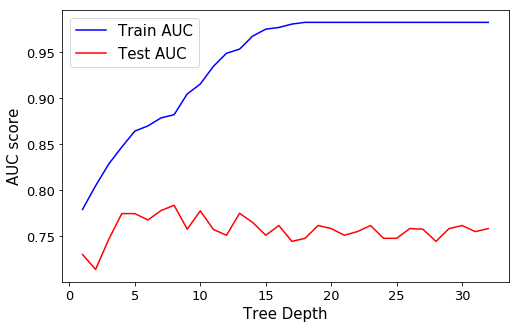

In [62]:
def visualize_learning_curves(feature_name, features, train_results, test_results):
    plt.figure(figsize=(8,5))
    line1 = plt.plot(features, train_results, 'b', label='Train AUC')
    line2 = plt.plot(features, test_results, 'r', label='Test AUC')
    plt.legend(loc='best', fontsize=15)
    plt.ylabel('AUC score', fontsize=15)
    plt.xlabel(feature_name, fontsize=15)
    plt.tick_params(labelsize=13)
    plt.show()


max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results, test_results = [], []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, _ = roc_curve(y_train, train_pred)
    train_results.append(auc(false_positive_rate, true_positive_rate))
    
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_pred)
    test_results.append(auc(false_positive_rate, true_positive_rate))


visualize_learning_curves('Tree Depth', max_depths, train_results, test_results)

We can see larger depth makes the models have higher score for training dataset, but not test dataset. Therefore high depth results in overfitting.

## Hyperparameter 2: min_samples_split

`min_samples_split` represents the minimum number of samples required to split an internal node. We can vary the parameter from 10% to 100% of the samples. We can clearly see that when we consider 100% of the samples at each node, the model cannot learn enough about the data. This is an **underfitting** case.

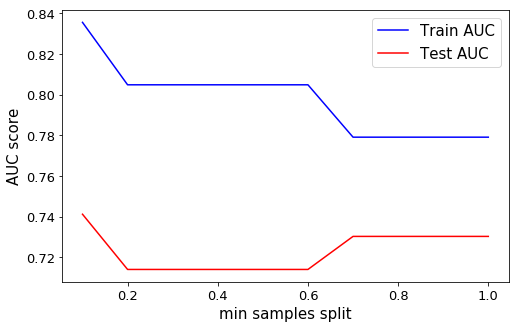

In [63]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results, test_results = [], []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    dt.fit(X_train, y_train)
    false_positive_rate, true_positive_rate, _ = roc_curve(y_train, dt.predict(X_train))
    train_results.append(auc(false_positive_rate, true_positive_rate))

    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, dt.predict(X_test))    
    test_results.append(auc(false_positive_rate, true_positive_rate))

visualize_learning_curves('min samples split', min_samples_splits, train_results, test_results)

## Hyperparameter 3: min_samples_leaf

`min_samples_leaf` is the minimum number of samples required in a leaf node. This parameter is similar to min_samples_splits; however, this describe the minimum number of samples of samples at the leafs, the base of the tree. Higher `min_samples_leaf` may cause **underfitting**.

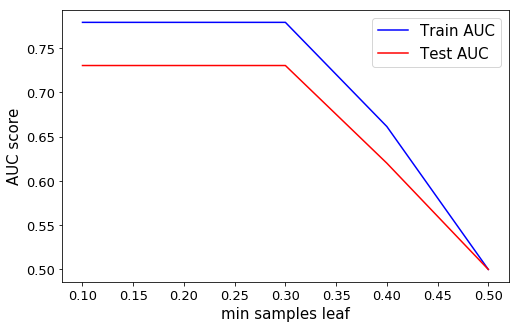

In [64]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results, test_results = [], []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dt.fit(X_train, y_train)
    false_positive_rate, true_positive_rate, _ = roc_curve(y_train, dt.predict(X_train))
    train_results.append(auc(false_positive_rate, true_positive_rate))

    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, dt.predict(X_test))
    test_results.append(auc(false_positive_rate, true_positive_rate))

visualize_learning_curves('min samples leaf', min_samples_leafs, train_results, test_results)

## Hyperparameter 4: max_features

`max_features` represents the number of features to consider when looking for the best split.

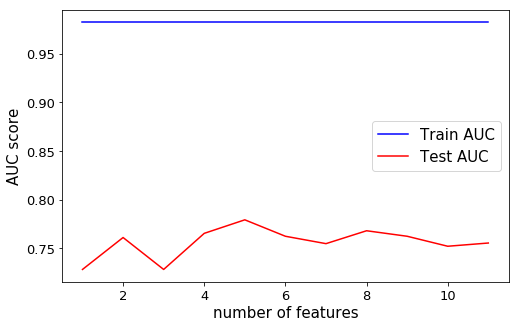

In [65]:
max_features = list(range(1, train_data.shape[1]))
train_results, test_results = [], []
for max_feature in max_features:
    dt = DecisionTreeClassifier(max_features=max_feature)
    dt.fit(X_train, y_train)
    false_positive_rate, true_positive_rate, _ = roc_curve(y_train, dt.predict(X_train))
    train_results.append(auc(false_positive_rate, true_positive_rate))
    
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, dt.predict(X_test))
    test_results.append(auc(false_positive_rate, true_positive_rate))

visualize_learning_curves('number of features', max_features, train_results, test_results)